#LÊ NGUYỄN TRUNG 19146024
#Code train model phân loại rác sử dụng CNN

**Tải datasets từ Kaggle**

In [ ]:
!pip install kaggle 

In [ ]:
!mkdir kaggle

In [ ]:
import os
import json 
kaggleAPIToken = {"username":"lenguyentrung","key":"53097035ab313b0e4ac545a7637f04f9"} ## Lấy API token trên tài khoản Kaggle
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(kaggleAPIToken, file)

In [ ]:
# !chmod 600 /content/kaggle/kaggle.json
# !sudo mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d lenguyentrung/inhput-garbage # Lấy API của dataset trên Kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘dataset’: File exists
inhput-garbage.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/inhput-garbage.zip # Giải nén dataset


**Tải các thư viện cần thiết**

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

**Chuẩn bị datasets**

In [ ]:
data_path = "/content/garbage_classification/" # Đường dẫn của dataset
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'] 

In [ ]:
## Hàm thêm class vào data frame
def add_class_name(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [ ]:
## Đọc path file rồi tạo Data frame
ds_ten_file = []
ds_categories = []
for category in categories:
    filenames = os.listdir(data_path + category) 
    ds_ten_file += filenames
    ds_categories += [category] * len(filenames)
df = pd.DataFrame({'filename': ds_ten_file,'category': ds_categories })
df = add_class_name(df, 'filename')
df = df.sample(frac=1).reset_index(drop=True)

**In các ảnh ngẫu nhiên trong tập dữ liệu ứng với phân loại**

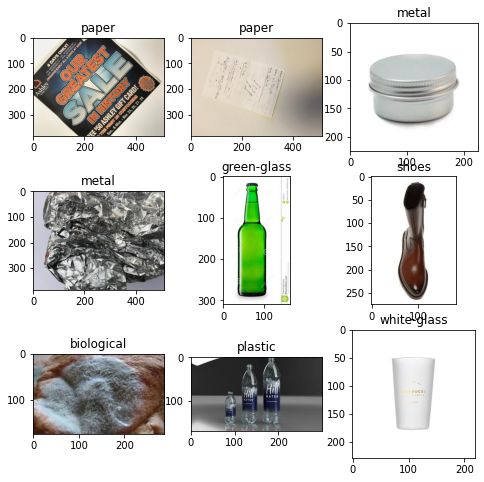

In [ ]:
## in ngẫu nhiên 9 ảnh từ trong dataset và class tương ứng
plt.figure(figsize=(8,8))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(data_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

**Vẽ biểu đồ phân bố số lượng của từng loại rác**

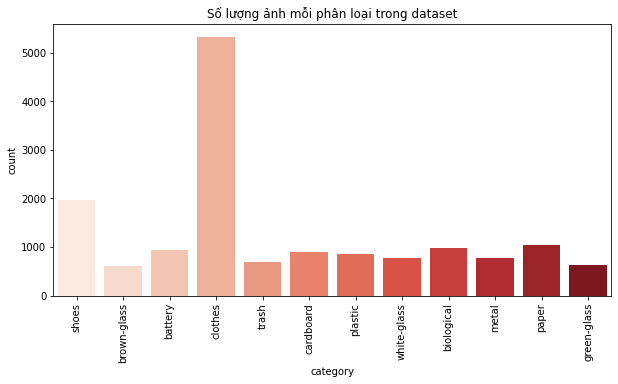

In [ ]:
## Vẽ biểu đồ phân bố số lượng ảnh ở mỗi class
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Reds')
plt.xticks(rotation=90)
plt.title('Số lượng ảnh mỗi phân loại trong dataset')
plt.show()

**Quan sát biểu đồ ta thấy dữ liệu bị imbalanced ở hai cột "Clothes" và "shoes" nên ta sẽ xử lý bằng cách drop hai cột này**

In [ ]:
clothesDrop=df[df['category']=='clothes'].sample(n=4400)
shoesDrop=df[df['category']=='shoes'].sample(n=900)
df.drop(labels=clothesDrop.index.values, inplace=True)
df.drop(labels=shoesDrop.index.values, inplace=True)

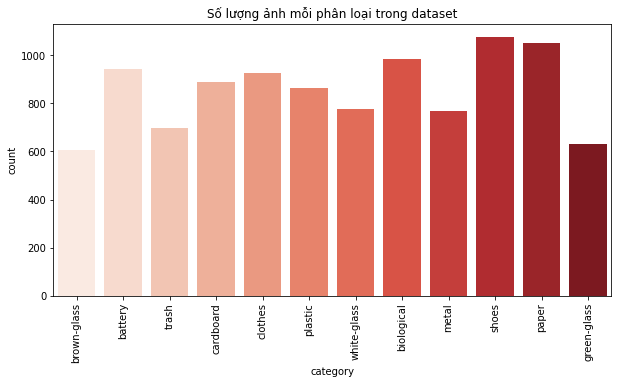

In [ ]:
## Sau khi xử drop vẽ lại đồ thị để quan sát
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Reds')
plt.xticks(rotation=90)
plt.title('Số lượng ảnh mỗi phân loại trong dataset')
plt.show()

**Chia dataset thành các tập Train, Test và Validation**

In [ ]:
## Chia tập dataset ra các tập train, test, val với tỉ lệ  8:1:1
train, val = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(val, test_size=0.5, random_state=42)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(val), len(test)

(8172, 1021, 1022)

Build model CNN

In [ ]:
im_shape = (256, 256) ## kích thước ảnh 
batch_size = 64       
seed = 42

## Sử dụng ImageDataGenerator để làm dày dữ liệu

In [ ]:
train_generator = ImageDataGenerator(horizontal_flip=True,  ## Lật ngang
                         vertical_flip=True,                ## Lật dọc 
                         validation_split=0.1,              ##
                         rescale=1./255,
                         rotation_range=90,
                         brightness_range= [0.5, 1.3],
                         zoom_range=[0.7,1.2],
                         width_shift_range = 0.2,
                         height_shift_range = 0.2
                        )
val_generator = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         rotation_range=90,
                         brightness_range= [0.5, 1.3],
                         zoom_range=[0.7,1.2],
                         width_shift_range = 0.2,
                         height_shift_range = 0.2)
test_generator = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         rotation_range=90,
                         brightness_range= [0.5, 1.3],
                         zoom_range=[0.7,1.2],
                         width_shift_range = 0.2,
                         height_shift_range = 0.2)

In [ ]:
train_generator = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 8172 validated image filenames belonging to 12 classes.


In [ ]:
val_generator = val_generator.flow_from_dataframe(
    dataframe=val,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical', ## 2D
    batch_size=batch_size,
    seed=seed)

Found 1021 validated image filenames belonging to 12 classes.


In [ ]:
test_generator = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=data_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 1022 validated image filenames belonging to 12 classes.


In [ ]:
nb_train_samples = train_generator.samples ## là số lượng sample trong tập train 
nb_validation_samples = val_generator.samples ## là số lượng sample trong tập val
nb_test_samples = test_generator.samples ## là số lượng sample trong tập train test
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


## Xây dựng model gồm 5 lớp

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.summary()
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 64)      

In [ ]:
## Đặt giá trị epoch để train
epochs = 100
# Hàm callback để lưu lại model nào tốt nhất sử dụng EarlyStopping để dừng train nếu sau 10 epoch mà val_loss ko giảm
callbacks_list = [ModelCheckpoint(filepath='model_19_6.h5',monitor='val_loss', save_best_only=True, verbose=1),EarlyStopping(monitor='val_loss', patience=10,verbose=1)]
#Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
127/127 [==============================] - ETA: 0s - loss: 2.2960 - accuracy: 0.1735
Epoch 1: val_loss improved from inf to 1.97862, saving model to model_19_6.h5
127/127 [==============================] - 146s 1s/step - loss: 2.2960 - accuracy: 0.1735 - val_loss: 1.9786 - val_accuracy: 0.3323
Epoch 2/100
127/127 [==============================] - ETA: 0s - loss: 1.8962 - accuracy: 0.3345
Epoch 2: val_loss improved from 1.97862 to 1.73894, saving model to model_19_6.h5
127/127 [==============================] - 144s 1s/step - loss: 1.8962 - accuracy: 0.3345 - val_loss: 1.7389 - val_accuracy: 0.3896
Epoch 3/100
127/127 [==============================] - ETA: 0s - loss: 1.7228 - accuracy: 0.3974
Epoch 3: val_loss did not improve from 1.73894
127/127 [==============================] - 142s 1s/step - loss: 1.7228 - accuracy: 0.3974 - val_loss: 1.7625 - val_accuracy: 0.4010
Epoch 4/100
127/127 [==============================] - ETA: 0s - loss: 1.6401 - accuracy: 0.4318
Epoch 4: 

In [ ]:
## Lưu model vào trong google Drive
model.save("/content/drive/MyDrive/lenguyentrung/model_19_6.h5")
model.save("model21.h5")

In [ ]:
np.save('history_12',history.history)

## Đánh giá mô hình

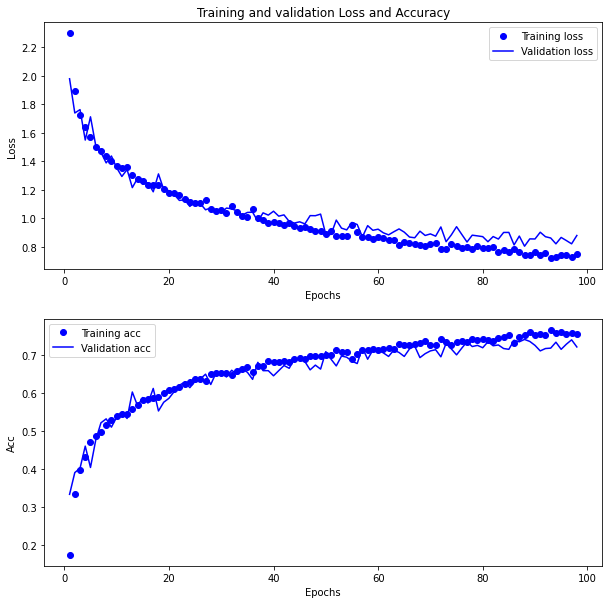

In [ ]:
# Vẽ đường Training curves
his_dict = history.history
loss_values = his_dict['loss']
val_loss_values = his_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = his_dict['accuracy']
val_acc_values = his_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model = load_model('/content/model_19_6.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

16/16 [==============================] - 16s 1s/step - loss: 0.9041 - accuracy: 0.7150
Val loss: 0.9040566682815552
Val accuracy: 0.7149853110313416


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1022/1022 [==============================] - 17s 17ms/step - loss: 0.7799 - accuracy: 0.7524
Test loss: 0.7799473404884338
Test accuracy: 0.752446174621582


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
              precision    recall  f1-score   support

     battery       0.79      0.79      0.79       103
  biological       0.83      0.79      0.81       107
 brown-glass       0.77      0.80      0.79        60
   cardboard       0.91      0.78      0.84        88
     clothes       0.65      0.77      0.71        64
 green-glass       0.85      0.94      0.89        53
       metal       0.71      0.59      0.65        86
       paper       0.73      0.79      0.76       105
     plastic       0.69      0.53      0.60        86
       shoes       0.66      0.72      0.69       116
       trash       0.77      0.71      0.74        70
 white-glass       0.62      0.74      0.67        84

    accuracy                           0.74      1022
   macro avg       0.75      0.75      0.74      1022
weighted avg       0.74      0.74      0.74      1022



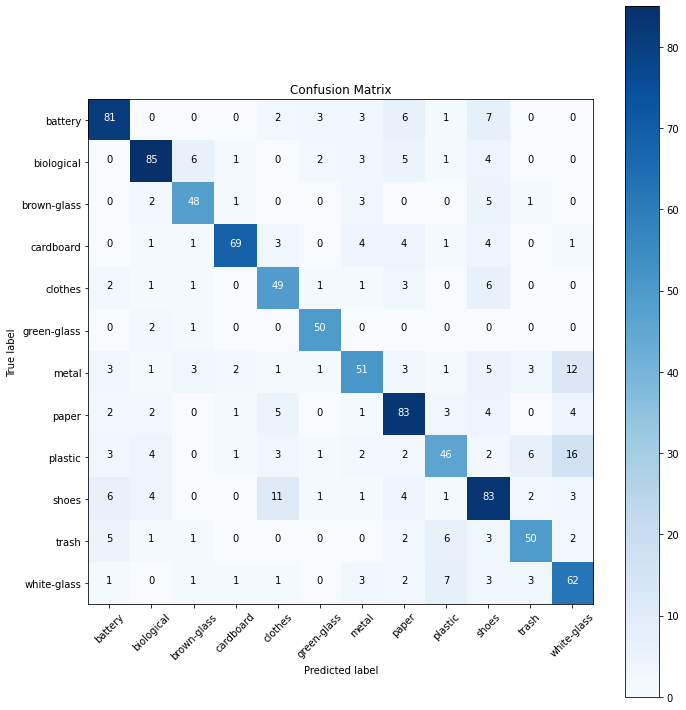

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

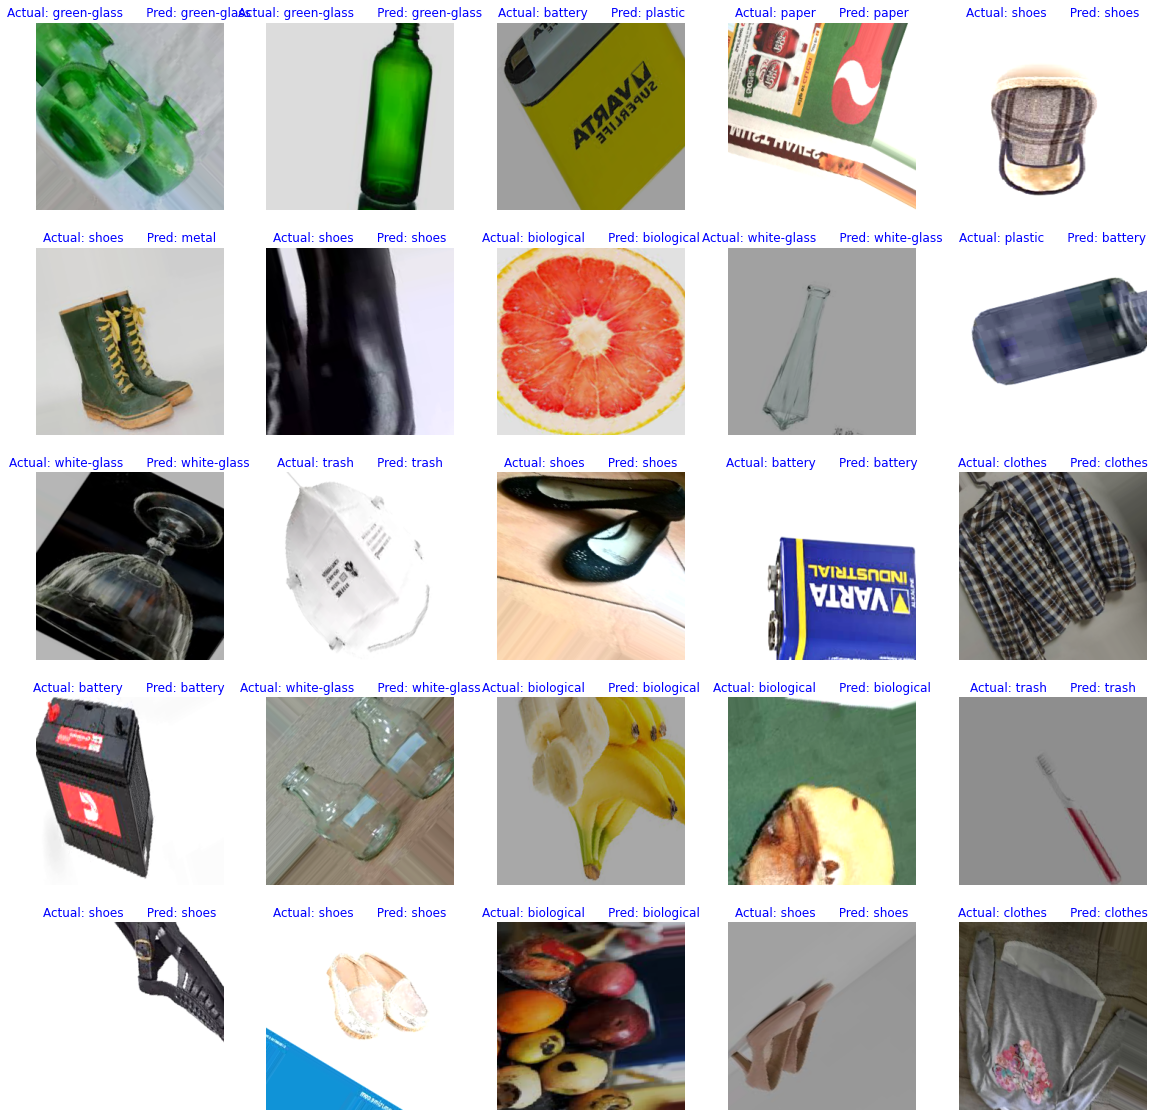

In [ ]:
def test_image_samples(gen ):
    
        t_dict=gen.class_indices
        classes=list(t_dict.keys())    
        images,labels=next(gen) # get a sample batch from the generator 
        preds = model.predict(images)
        preds = preds.argmax(1)
        plt.figure(figsize=(20, 20))
        length=len(labels)
        if length<25:   #show maximum of 25 images
            r=length
        else:
            r=25
        for i in range(r):
            plt.subplot(5, 5, i + 1)
            image=images[i]
            plt.imshow(image)
            index=np.argmax(labels[i])
            class_name=classes[index]
            class_name_pred=classes[preds[i]]
            plt.title('Actual: {}      Pred: {}'.format(class_name,class_name_pred),  color='blue', fontsize=12)
            plt.axis('off')
        plt.show()

test_image_samples(val_generator)